## Problem: Adversarial Noise

In [1]:
%cd /home/ec2-user/SageMaker/MNIST/adversarial-noise-generator

/home/ec2-user/SageMaker/MNIST/adversarial-noise-generator


In [ ]:
# !pip install tensorboard

In [2]:
!python train.py

device: cpu
[Friday 15:04] Preparing datasets...
Found 480 training examples
Found 160 validation examples
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
VGG16 model restored and modified for 10 classes.
num_epochs: 10
epoch 1/10
1/15, train_loss: 2.3741, train_acc:0.09
2/15, train_loss: 2.3836, train_acc:0.03
3/15, train_loss: 2.3383, train_acc:0.06
4/15, train_loss: 2.3648, train_acc:0.12
5/15, train_loss: 2.3126, train_acc:0.06
6/15, train_loss: 2.2930, train_acc:0.19
7/15, train_loss: 2.2951, train_acc:0.12
8/15, train_loss: 2.2617, train_acc:0.16
9/15, train_loss: 2.2381, train_acc:0.12
10/15, train_loss: 2.2519, train_acc:0.06
11/15, train_loss: 2.2200, train_acc:0.12
12/15, train_loss: 2.2050, train_acc:0.19
13/15, train_loss: 2.3031, train_acc:0.16
1

In [9]:
import mnist_dataset
import torchvision.transforms as transforms
from torchvision.transforms import Compose


TRAIN_SUBSET_SIZE = 640
VALID_SUBSET_SIZE = 16
BATCH_SIZE = 16

train_transform = Compose([transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))])

valid_transform = Compose([transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))])

mnist_ds = mnist_dataset.MNISTDataset(batch_size=BATCH_SIZE, 
                                         train_transform=train_transform,
                                         valid_transform=valid_transform,
                                         train_subset_size=TRAIN_SUBSET_SIZE,
                                         valid_subset_size=VALID_SUBSET_SIZE)

data_loaders = mnist_ds.get_data_loader(batch_size=BATCH_SIZE)

train_loader = data_loaders['train']
valid_loader = data_loaders['valid']

[Friday 16:01] Preparing datasets...
Found 640 training examples
Found 16 validation examples


In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def imshow(image_tensor, title=None):
    
    images = image_tensor.squeeze().detach().numpy()  

    fig, axes = plt.subplots(1, 16, figsize=(10, 5))  
    for i in range(16):

        image = images[i]
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off') 
        if title:
            axes[0].set_title(title[0] if isinstance(title, list) else title)

    plt.tight_layout()
    plt.show()


In [12]:
import cnn_classifier
import torch.nn as nn
import torchvision
from torchvision.models import VGG16_Weights


BATCH_SIZE = 16
MAX_EPOCHS = 10
CLS_TARGET = 5
NUM_CLASSES = 10
IN_CHANNELS = 1
LEARNING_RATE = 1e-5
WEIGTH_DECAY=1e-3
DROP_OUT_PROB = 0.5

LOG_DIR = '/home/ec2-user/SageMaker/MNIST/results/'
cnn = cnn_classifier.CNNClassifier(learning_rate=LEARNING_RATE,
                                           max_epochs=MAX_EPOCHS,
                                           batch_size=BATCH_SIZE,
                                           num_classes=NUM_CLASSES,
                                           log_dir=LOG_DIR + '/logs',  
                                           dropout_prob=0.5,   
                                           restore_model_path=None,  
                                           dataset=mnist_ds)
    
weights = VGG16_Weights.DEFAULT  # Loads pretrained weights
model = cnn.vgg_model(in_channels=IN_CHANNELS, num_classes=NUM_CLASSES, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGTH_DECAY)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


VGG16 model restored and modified for 10 classes.


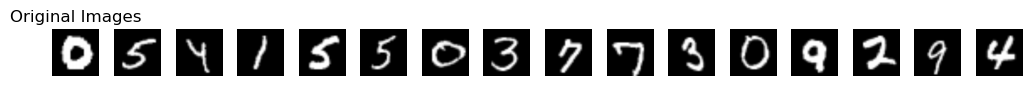

labels: [0 5 4 1 5 5 0 3 7 7 3 0 9 2 9 4]


In [13]:
for images, labels in valid_loader:
    images, labels = images, labels
    images.requires_grad = True
    labels = labels.long()
    
    imshow(images[:16], title="Original Images")
    print("labels:", labels[:16].cpu().numpy())

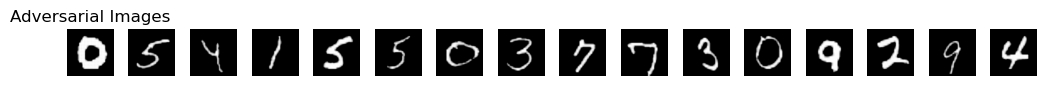

 Adv labels: [0 5 4 1 5 5 0 3 7 7 3 0 9 2 9 4]


In [14]:
for batch_data in valid_loader:
    images, labels = batch_data[0], batch_data[1]
    images.requires_grad = True
    labels = labels.long()
    
    adv_images = cnn.generate_adversarial_noise(model, criterion, images, labels, cls_target=CLS_TARGET, epsilon=0.01, targeted=False)
    adv_images = adv_images.cpu()
    imshow(adv_images[:16], title="Adversarial Images")
    print(" Adv labels:", labels[:16].cpu().numpy())
    